In [205]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from scipy import signal
from scipy.signal import butter, filtfilt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from neural_network_architectures import (
    QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d
)

from helper_functions import extract_spectrograms

# Add custom module path
module_path = os.path.abspath(os.path.join('scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

# IRIS client instance
client = Client('IRIS')

from typing import Any


## Loading the trained models

In [100]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('trained_models/best_model_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('trained_models/best_model_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('trained_models/best_model_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)


/tmp/ipykernel_3060574/2645211226.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('trained_models/best_model_SeismicCNN_2d.pth', 

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

## Checking the labels of some events in the exotic event catalog

In [90]:
# Set parameters outside the loop
fs_original = 100
fs_target = 50
taper_alpha = 0.1
lowcut, highcut = 1, 20
nperseg = 256
overlap = 0.5
noverlap = int(nperseg * overlap)
nyquist = 0.5 * fs_original
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')


model = model_quakexnet_2d
model.eval()
preds = []

for i in tqdm(range(100)):
    try:
        # --- 1. Extract metadata ---
        event = exotic.iloc[i]
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        starttime = UTCDateTime(event["trace_start_time"])

        # --- 2. Download waveform ---
        stream = client.get_waveforms(
            network=network, station=station, channel=f"{channel}?",
            location="--", starttime=starttime - 10, endtime=starttime + 90
        )
        stream.detrend()
        stream.resample(fs_original)
        waveform = np.array(stream)  # shape: (3, N)
        

        # --- 3. Preprocess waveform ---
        taper = signal.windows.tukey(waveform.shape[-1], alpha=taper_alpha)
        tapered = waveform * taper
        filtered = np.array([signal.filtfilt(b, a, tr) for tr in tapered])
        num_samples = int(filtered.shape[1] * fs_target / fs_original)
        
        resampled = np.array([signal.resample(tr, num_samples) for tr in filtered])
        resampled = resampled[:, :5000].reshape(1, 3, 5000)

        
        # normalizing (don't forget this step)
        mmax = np.std(np.abs(resampled))
        # store data in big index
        x = resampled/mmax
        
        
        # --- 4. Extract spectrogram ---
        spectrogram = extract_spectrograms(x)
        
        
        
        # --- 5. Run model ---
        inputs = torch.Tensor(spectrogram).to(device)
        with torch.no_grad():
            outputs = model(inputs)
            
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds.append(probs.argmax(1).item())
        

    except Exception as e:
        print(f"Error processing event {i}: {e}")
        preds.append(None)  # Placeholder for failed events


 52%|█████▏    | 52/100 [00:36<00:29,  1.65it/s]

Error processing event 51: No data available for request.
HTTP Status code: 204
Detailed response of server:





100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


## Plotting the labels 

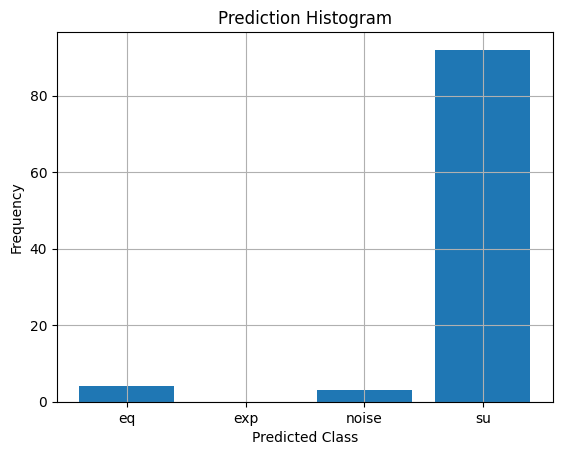

In [91]:
plt.hist(clean_preds, bins=np.arange(5)-0.5, rwidth=0.8)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Prediction Histogram")
plt.xticks([0, 1, 2, 3], ['eq', 'exp', 'noise', 'su'])  # ✅ Correct line
plt.grid(True)
plt.show()


## Plotting the labels

## Plotting a single event and comparing with the seisbench

In [119]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:32:46.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:28:28.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:56.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:51.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:07:29.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:29:40.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:11:46.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:11:49.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:48:28.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [120]:
event = exotic.iloc[11]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3173148
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SEP
station_location_code                              --
station_latitude_deg                             46.2
station_longitude_deg                        -122.191
station_elevation_m                            2114.0
trace_name                       bucket1$62,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-10-14T01:27:47.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                      4.385|-4.590|-3.941
Name: 417, dtype: object


3 Trace(s) in Stream:
CC.SEP..BHE | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples
CC.SEP..BHN | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples
CC.SEP..BHZ | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples


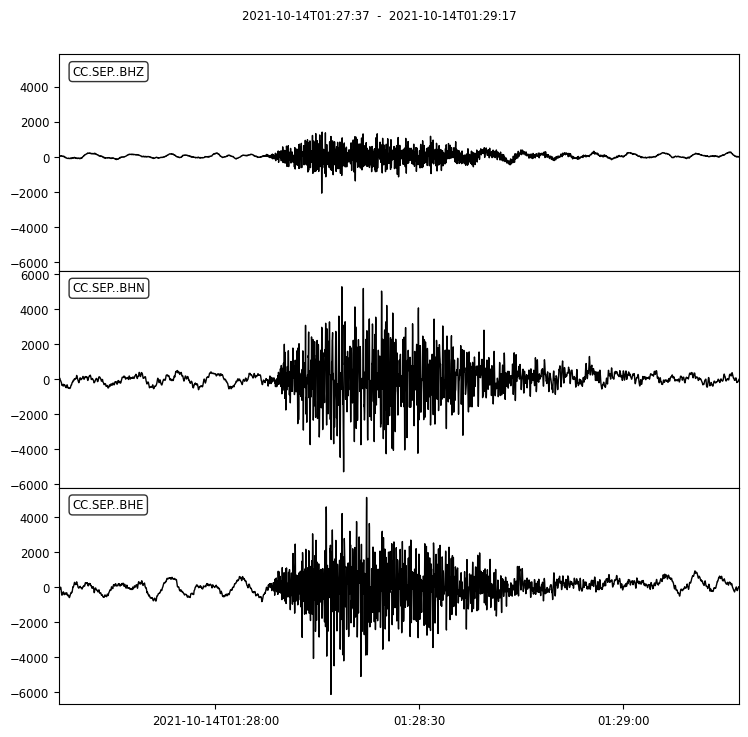

In [133]:
## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)

s.detrend()
s.resample(50)
print(s)
s.plot();

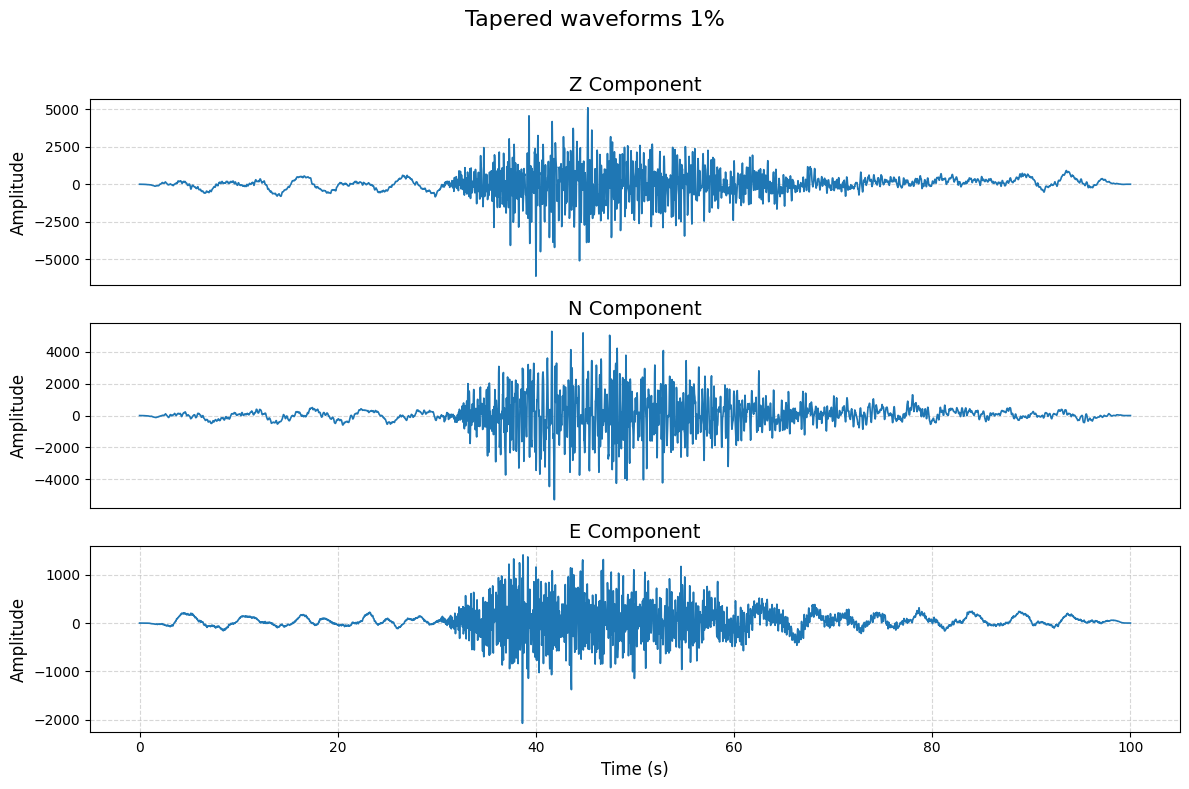

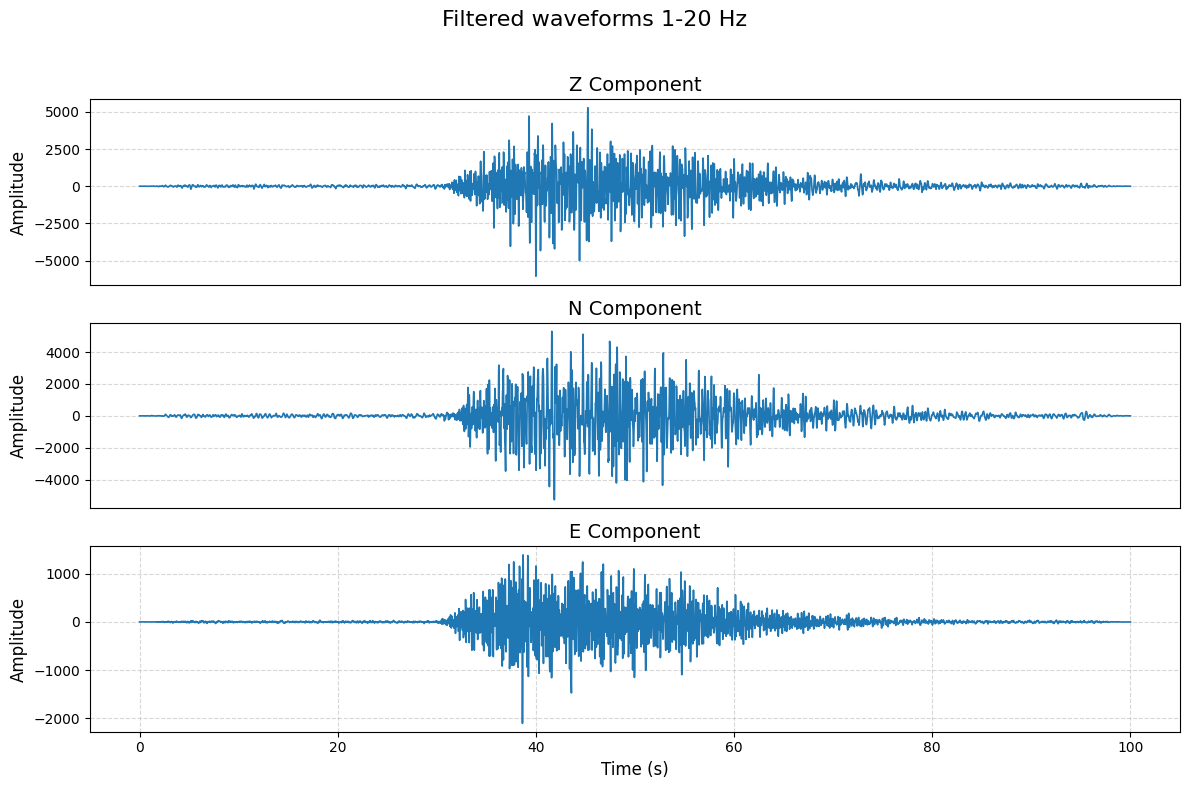

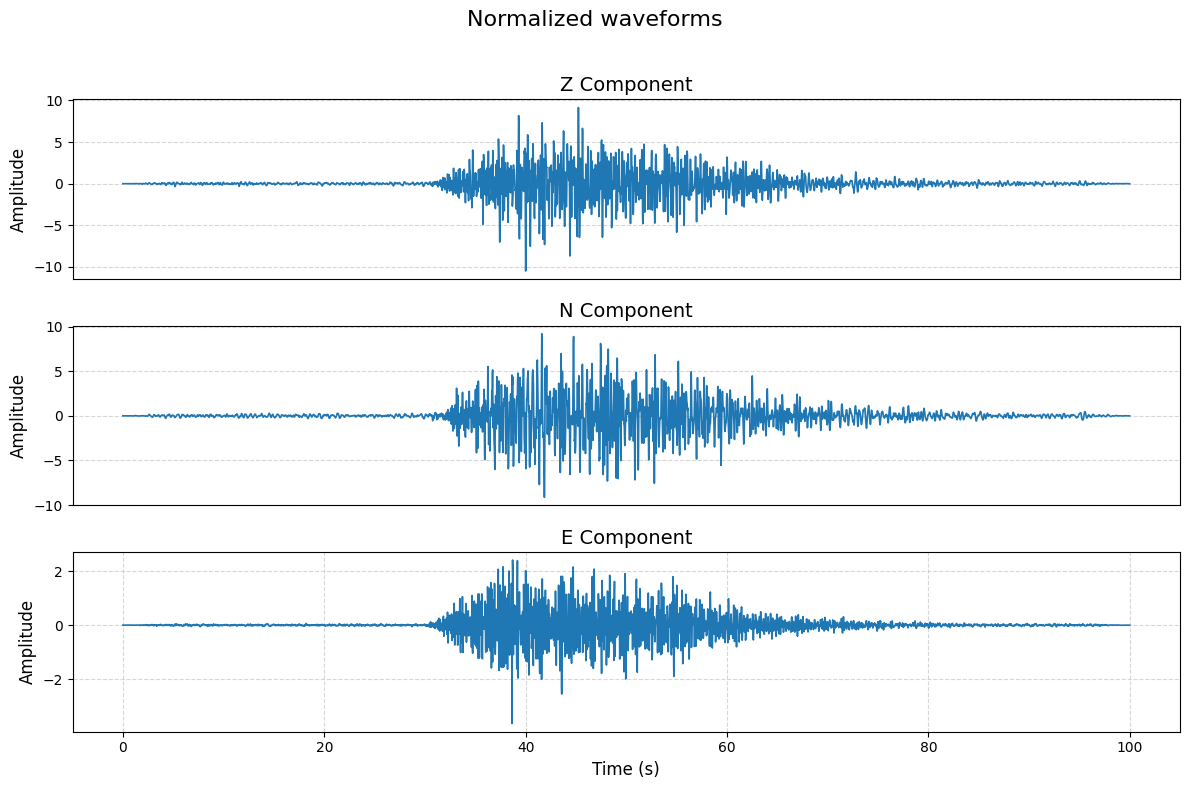

In [135]:
# amount of tapering
taper_alpha = 0.1

# filter parameters
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
lowcut = 1
highcut = 20
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients


# resampled frequency 
fs = 50

# event data
event_data = np.array(s)

# tapering before filtering
taper = signal.windows.tukey(event_data.shape[-1], alpha=taper_alpha)
tapered_data = np.array([np.multiply(taper, row) for row in event_data])



# Plotting tapered waveforms
waveform = tapered_data
components = ['Z', 'N', 'E']
fs = 50  # sampling rate in Hz
time = np.arange(waveform.shape[1]) / fs  # convert sample index to seconds

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(time, waveform[i], linewidth=1.2)
    plt.title(f"{components[i]} Component", fontsize=14)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    if i == 2:
        plt.xlabel("Time (s)", fontsize=12)
    else:
        plt.xticks([])  # hide x-ticks for top plots to reduce clutter

plt.suptitle(f"Tapered waveforms 1%", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust layout to fit suptitle
plt.show()




    
#Apply bandpass filtering
filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])




# Plot filtered waveforms

waveform = filtered_data
components = ['Z', 'N', 'E']
fs = 50  # sampling rate in Hz
time = np.arange(waveform.shape[1]) / fs  # convert sample index to seconds

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(time, waveform[i], linewidth=1.2)
    plt.title(f"{components[i]} Component", fontsize=14)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    if i == 2:
        plt.xlabel("Time (s)", fontsize=12)
    else:
        plt.xticks([])  # hide x-ticks for top plots to reduce clutter

plt.suptitle(f"Filtered waveforms 1-20 Hz", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust layout to fit suptitle
plt.show()


# Resample the data to the target sampling rate
num_samples = int(filtered_data.shape[1] * fs / 50)  # Resample to target `fs`
resampled_data = np.array([signal.resample(row, num_samples) for row in filtered_data])


resampled_data = resampled_data[:,0:5000]
resampled_data = resampled_data.reshape(1,3, 5000)

mmax = np.std(np.abs(resampled_data[0]))
norm = resampled_data/mmax



# plotting the normalized waveform
waveform = norm[0]
components = ['Z', 'N', 'E']
fs = 50  # sampling rate in Hz
time = np.arange(waveform.shape[1]) / fs  # convert sample index to seconds

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(time, waveform[i], linewidth=1.2)
    plt.title(f"{components[i]} Component", fontsize=14)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    if i == 2:
        plt.xlabel("Time (s)", fontsize=12)
    else:
        plt.xticks([])  # hide x-ticks for top plots to reduce clutter

plt.suptitle(f"Normalized waveforms", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust layout to fit suptitle
plt.show()


In [136]:
nperseg=256
overlap=0.5
fs = 50
noverlap = int(nperseg * overlap)  # Calculate overlap
f, t, _ = signal.spectrogram(norm, nperseg=nperseg, noverlap=noverlap, fs=fs)

spectrogram = extract_spectrograms(norm)

100%|██████████| 1/1 [00:00<00:00, 1031.05it/s]


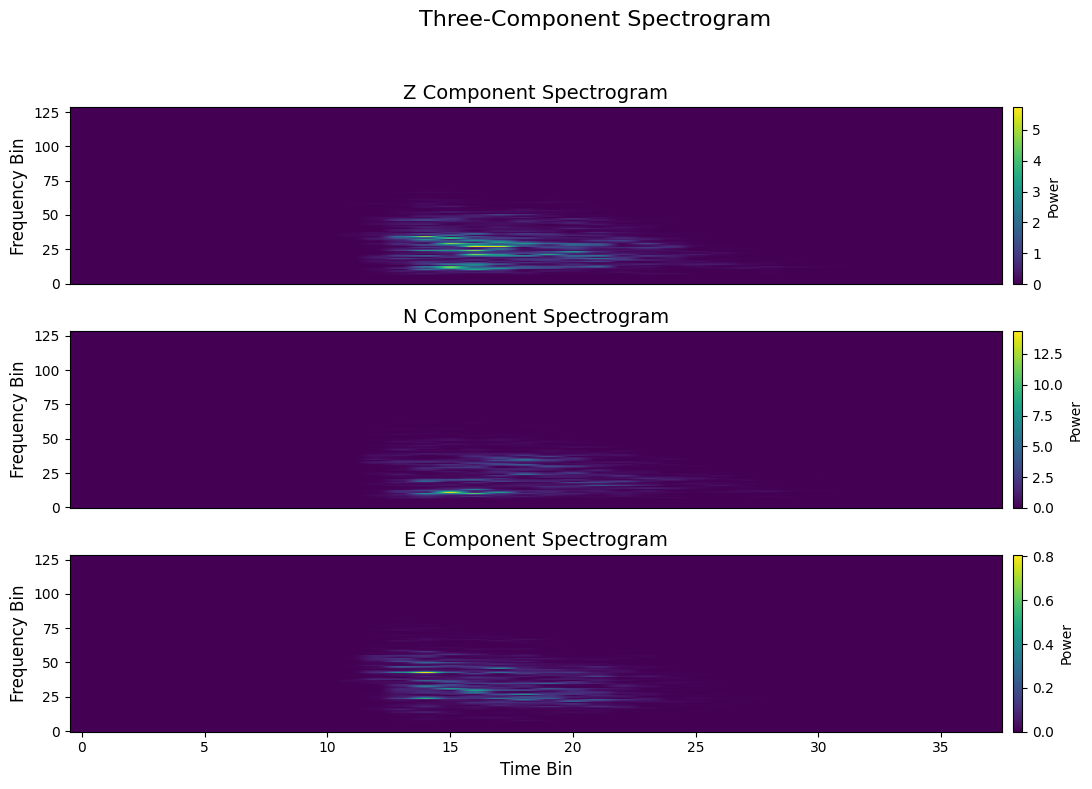

In [137]:
# Assume `spectrogram` has shape (1, 3, 129, 38)
# spectrogram = your_spectrogram_array
# f, t = frequencies and times from signal.spectrogram

components = ['Z', 'N', 'E']
spec = spectrogram[0]  # Remove batch dimension, now shape (3, 129, 38)

# Assume `spectrogram` is a torch.Tensor of shape (1, 3, 129, 38)
spec = spectrogram[0] # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(spec[i], aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{components[i]} Component Spectrogram", fontsize=14)
    plt.ylabel("Frequency Bin", fontsize=12)
    plt.colorbar(label='Power', pad=0.01)
    if i == 2:
        plt.xlabel("Time Bin", fontsize=12)
    else:
        plt.xticks([])

plt.suptitle("Three-Component Spectrogram", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [128]:
model = model_quakexnet_2d
inputs = torch.Tensor(spectrogram).to(device)
outputs = model(inputs)
probs = torch.nn.functional.softmax(outputs, dim=1)
probs.argmax(1)

tensor([3], device='cuda:0')

In [129]:
probs

tensor([[0.0061, 0.0044, 0.0018, 0.9877]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

## Seisbench functions

In [154]:
event_data = event_data[:,:5000]
event_data = event_data.reshape(1,3, 5000)

In [155]:
batch = torch.tensor(event_data)

In [156]:
detrended_batch = linear_detrend(batch)

In [170]:
# tapering

device = 'cpu'
tukey_window = scipy.signal.windows.tukey(detrended_batch.shape[-1], alpha=0.1)

# Convert the Tukey window to a PyTorch tensor
taper = torch.tensor(tukey_window, device=batch.device)
        

# Apply the Tukey window to the batch
tapered_batch = detrended_batch * taper  # Broadcasting over last axis
    

filtered_batch = bandpass_filter(tapered_batch)

In [186]:
data1 = tapered_data[0]
data2 = tapered_batch[0][0]

In [180]:
seisbench_norm = norm_batch[0][0].numpy()

local_norm = norm[0][1]

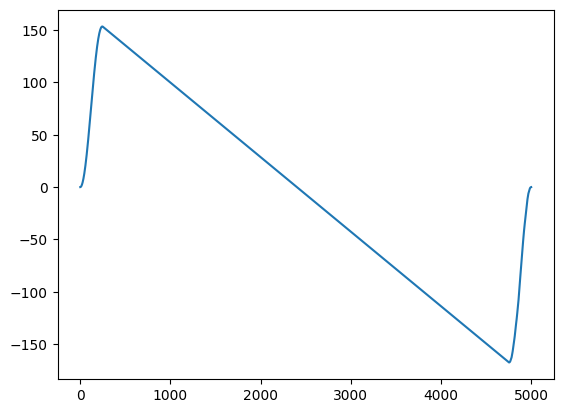

In [188]:
plt.plot(data2 - data1[0:5000])

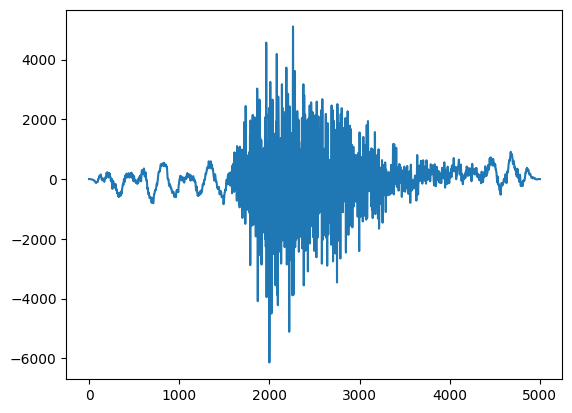

In [190]:
plt.plot(data1)

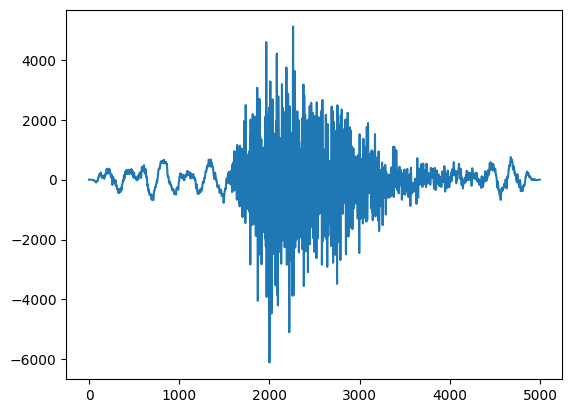

In [189]:
plt.plot(data2)

## Seisbench implementation

## Ok these are the processing steps followed. 

- Download the stream data from IRIS DMC
- Resample to 50 Hz
- Detrend
- Taper
- Filter
- Normalize
- Extract Spectrogram. 


We will compare each step of the seisbench implementation with the local implementation to figure out the problem. 

In [207]:
lowcut = 1
highcut = 20
fs = 50


def linear_detrend(tensor: torch.Tensor) -> torch.Tensor:
    """
    Apply linear detrending similar to ObsPy.
    """
    # Time indices
    time = torch.arange(tensor.shape[-1], dtype=tensor.dtype, device=tensor.device)

    # Calculate linear fit coefficients using least squares
    time_mean = time.mean()
    time_variance = ((time - time_mean) ** 2).sum()
    slope = ((tensor * (time - time_mean)).sum(dim=-1, keepdim=True)) / time_variance
    intercept = tensor.mean(dim=-1, keepdim=True) - slope * time_mean

    # Compute the trend
    trend = slope * time + intercept

    # Remove the trend from the original tensor
    return tensor - trend



# Apply the filter using filtfilt
def bandpass_filter(batch: torch.Tensor, fs: float, lowcut: float, highcut: float, order = 4) -> torch.Tensor:
    # Convert tensor to numpy array
    input_numpy = batch.numpy()  # Shape: (batch_size, num_channels, window_length)

    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b,a  = butter(order, [low, high], btype = 'band')

    # Apply the bandpass filter to each batch and each channel
    filtered_numpy = np.zeros_like(input_numpy)
    for i in range(input_numpy.shape[0]):  # Iterate over batch size
        for j in range(input_numpy.shape[1]):  # Iterate over channels
            filtered_numpy[i, j, :] = filtfilt(b, a, input_numpy[i, j, :])

    # Convert back to tensor
    filtered_tensor = torch.tensor(filtered_numpy)
    return filtered_tensor




In [209]:
## Downloading the data 
s = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime-10, endtime=starttime+90)



# resample to 50 Hz
s.resample(50)



# converting into array
event_data = np.array(s)[:, :5000]

# reshaping for shape compatibility
event_data = event_data.reshape(1, 3, 5000)

# converting into pytorch tensor. 
batch = torch.tensor(event_data)



# detrending
detrended_batch = linear_detrend(batch)



# tapering
device = 'cpu'
tukey_window = scipy.signal.windows.tukey(detrended_batch.shape[-1], alpha=0.1)

# Convert the Tukey window to a PyTorch tensor
taper = torch.tensor(tukey_window, device=batch.device)
        
# Apply the Tukey window to the batch
tapered_batch = detrended_batch * taper  # Broadcasting over last axis
    


    
# filtering 
filtered_batch = bandpass_filter(tapered_batch, fs, lowcut, highcut)



# Normalize each component by the standard deviation of their absolute values
batch_abs = torch.abs(filtered_batch)
std_abs = batch_abs.std(dim=-1, keepdim=True)
norm_batch = filtered_batch / (std_abs + 1e-10)  # Avoid division by zero

In [210]:
data2 = tapered_batch[0][0]

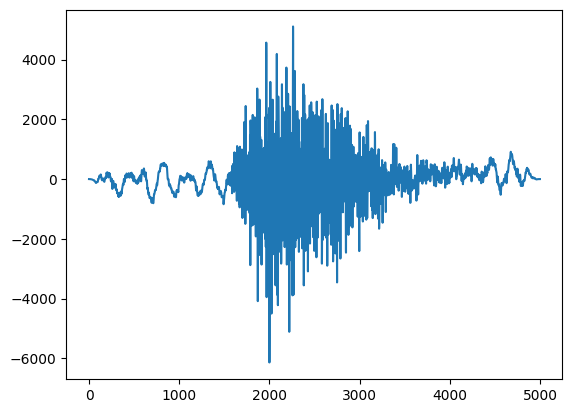

In [211]:
plt.plot(data1)

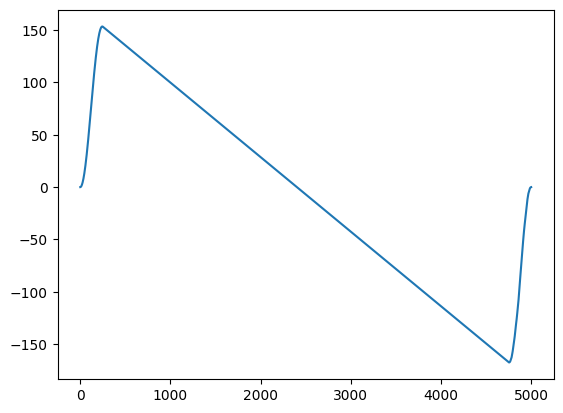

In [212]:
plt.plot(data2-data1)